In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [3]:
ls data/

sales_data.csv         test.csv
sample_submission.csv  train.csv


In [59]:
df = pd.read_csv('data/train.csv')
df.shape

(913000, 4)

In [60]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [61]:
#set datatime to index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [62]:
#split into train and test sets
train = df.loc['2013-01-01':'2017-09-30']
test = df.loc['2017-10-01':'2017-12-31']

In [63]:
y_train = train.pop('sales')
X_train = train.copy()
y_test =  test.pop('sales')
X_test = test.copy()

In [64]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(867000, 2) (867000,) (46000, 2) (46000,)


In [65]:
df.sales.sum()==y_train.sum()+y_test.sum()

True

### ARIMA Model

### Modeling by daily

In [99]:
daily_avg_sales = df['sales'].resample('D').mean()
daily_avg_sales.head()

date
2013-01-01    27.392
2013-01-02    27.356
2013-01-03    28.976
2013-01-04    31.354
2013-01-05    32.474
Freq: D, Name: sales, dtype: float64

In [100]:
decomposition = sm.tsa.seasonal_decompose(daily_avg_sales, model='additive')

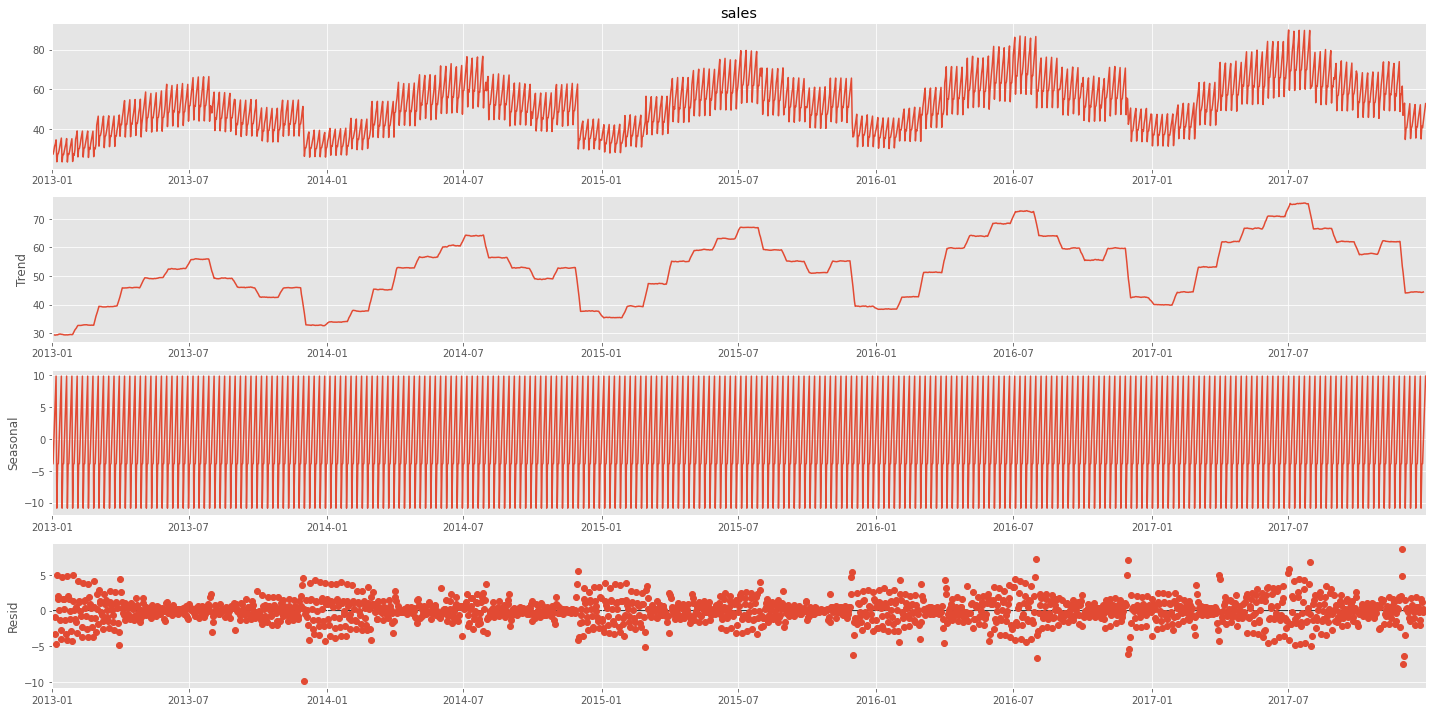

In [101]:
plt.rcParams['figure.figsize'] = 20, 10
fig = decomposition.plot()
plt.show()

In [102]:
model_1 = sm.tsa.statespace.SARIMAX(daily_avg_sales,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = model_1.fit()

In [103]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2190      0.035      6.200      0.000       0.150       0.288
ma.L1         -0.8959      0.015    -57.956      0.000      -0.926      -0.866
ma.S.L12      -1.0000     53.511     -0.019      0.985    -105.879     103.879
sigma2        54.5900   2921.032      0.019      0.985   -5670.527    5779.707


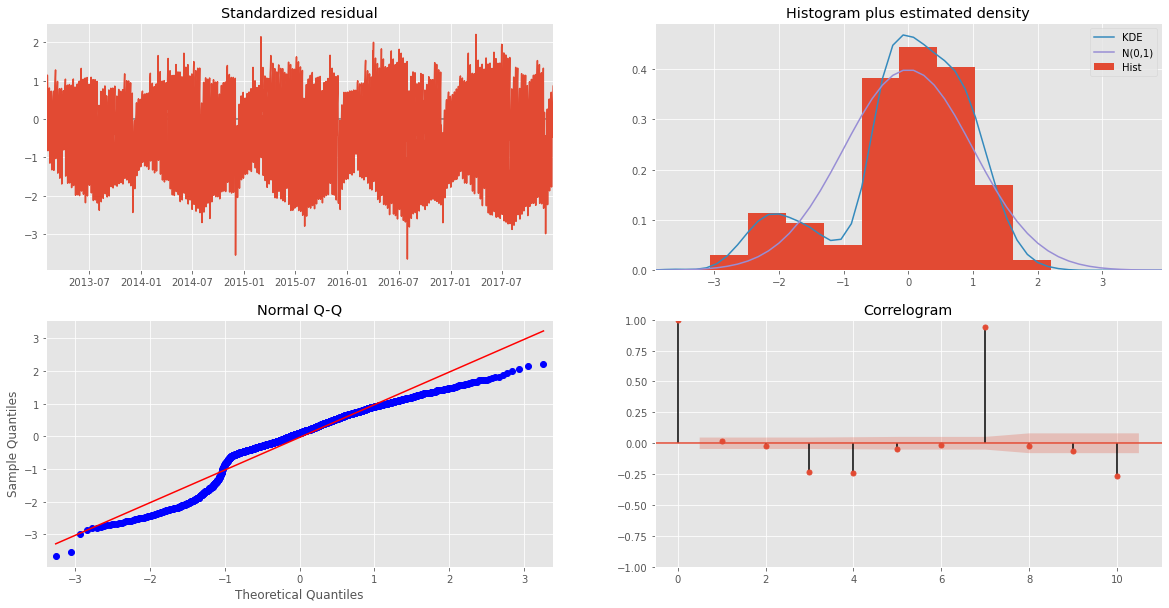

In [104]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

In [105]:
#MODEL Evaluation and Analysis

In [106]:
pred = results.get_prediction(start=pd.to_datetime('2017-10-01'), dynamic=False)

In [107]:
#Confidence interval
pred_ci = pred.conf_int()

In [108]:
pred_ci.head()

,lower sales,upper sales
date,,
2017-10-01,49.923872,78.986676
2017-10-02,49.951170,79.013958
2017-10-03,43.064868,72.127642
2017-10-04,44.541872,73.604635
2017-10-05,43.812782,72.875536


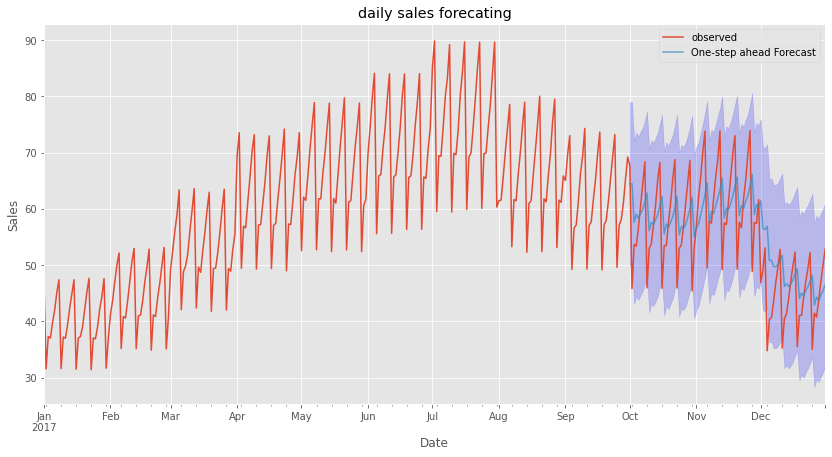

In [110]:
#Plotting real and forecasted values.

ax = daily_avg_sales['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title("daily sales forecating")
plt.legend()
plt.show()







In [111]:
#Calculating the Forecast Accuracy

#Calculating the mean squared error (average error of forecasts) and the lower Mean Square Error always reflects the better results 
y_forecasted = pred.predicted_mean
y_truth = daily_avg_sales['2017-10-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

MSE 63.26
RMSE: 7.95


In [112]:
df['sales'].mean()

52.250286966046005

#### Modeling by item and store

### Multivariate LSTM Forecast Model